In [1]:
import tensorflow as tf

In [2]:
from tensorflow import lite
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import random, os
import shutil
import matplotlib.pyplot as plt
from matplotlib.image import imread
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import categorical_accuracy
from sklearn.model_selection import train_test_split

In [3]:
df = pd.read_csv('D:/Diabetic Retinopathy/APTOS/train.csv')

diagnosis_dict_binary = {
    0: 'No_DR',
    1: 'DR',
    2: 'DR',
    3: 'DR',
    4: 'DR'
}

diagnosis_dict = {
    0: 'No_DR',
    1: 'Mild',
    2: 'Moderate',
    3: 'Severe',
    4: 'Proliferate_DR',
}


df['binary_type'] =  df['diagnosis'].map(diagnosis_dict_binary.get)
df['type'] = df['diagnosis'].map(diagnosis_dict.get)
df.head()

,id_code,diagnosis,binary_type,type
0,000c1434d8d7,2,DR,Moderate
1,001639a390f0,4,DR,Proliferate_DR
2,0024cdab0c1e,1,DR,Mild
3,002c21358ce6,0,No_DR,No_DR
4,005b95c28852,0,No_DR,No_DR


<Axes: xlabel='type'>

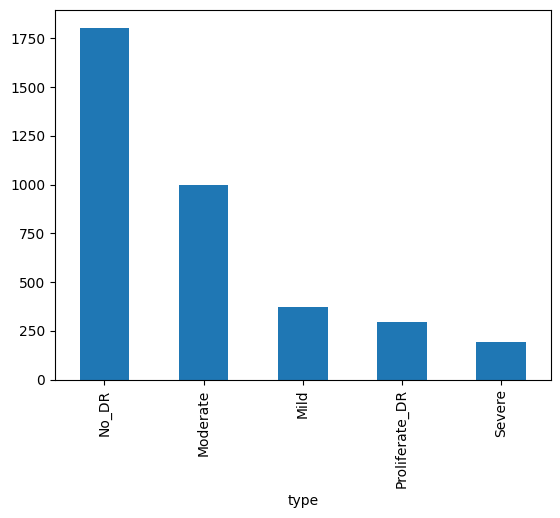

In [4]:
df['type'].value_counts().plot(kind='bar')

<Axes: xlabel='binary_type'>

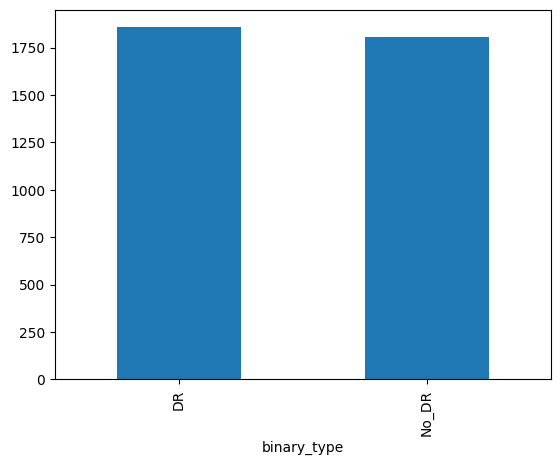

In [5]:
df['binary_type'].value_counts().plot(kind='bar')

In [6]:
train_intermediate, val = train_test_split(df, test_size = 0.15, stratify = df['type'])
train, test = train_test_split(train_intermediate, test_size = 0.15 / (1 - 0.15), stratify = train_intermediate['type'])

print(train['type'].value_counts(), '/n')
print(test['type'].value_counts(), '/n')
print(val['type'].value_counts(), '/n')


type
No_DR             1263
Moderate           699
Mild               258
Proliferate_DR     207
Severe             135
Name: count, dtype: int64 

type
No_DR             271
Moderate          150
Mild               56
Proliferate_DR     44
Severe             29
Name: count, dtype: int64 

type
No_DR             271
Moderate          150
Mild               56
Proliferate_DR     44
Severe             29
Name: count, dtype: int64 



In [7]:
base_dir = ''

train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

if os.path.exists(base_dir):
    shutil.rmtree(base_dir)

if os.path.exists(train_dir):
    shutil.rmtree(train_dir)
os.makedirs(train_dir)

if os.path.exists(val_dir):
    shutil.rmtree(val_dir)
os.makedirs(val_dir)

if os.path.exists(test_dir):
    shutil.rmtree(test_dir)
os.makedirs(test_dir)


In [8]:
# Copy images to respective working directory
src_dir = 'D:/Diabetic Retinopathy/APTOS/colored_images'
for index, row in train.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['binary_type']
    id_code = row['id_code'] + ".png"
    srcfile = os.path.join(src_dir, diagnosis, id_code)
    dstfile = os.path.join(train_dir, binary_diagnosis)
    os.makedirs(dstfile, exist_ok = True)
    shutil.copy(srcfile, dstfile)

for index, row in val.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['binary_type']
    id_code = row['id_code'] + ".png"
    srcfile = os.path.join(src_dir, diagnosis, id_code)
    dstfile = os.path.join(val_dir, binary_diagnosis)
    os.makedirs(dstfile, exist_ok = True)
    shutil.copy(srcfile, dstfile)
 
for index, row in test.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['binary_type']
    id_code = row['id_code'] + ".png"
    srcfile = os.path.join(src_dir, diagnosis, id_code)
    dstfile = os.path.join(test_dir, binary_diagnosis)
    os.makedirs(dstfile, exist_ok = True)
    shutil.copy(srcfile, dstfile)


In [9]:
# Setting up ImageDataGenerator for train/val/test 

train_path = 'train'
val_path = 'val'
test_path = 'test'

train_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(train_path, target_size=(224,224), shuffle = True)
val_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(val_path, target_size=(224,224), shuffle = True)
test_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(test_path, target_size=(224,224), shuffle = False)


Found 2562 images belonging to 2 classes.
Found 550 images belonging to 2 classes.
Found 550 images belonging to 2 classes.


In [10]:
from PIL import Image
from keras.preprocessing.image import load_img

In [11]:
model = tf.keras.Sequential([
    layers.Conv2D(8, (3,3), padding="valid", input_shape=(224,224,3), activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),
    
    layers.Conv2D(16, (3,3), padding="valid", activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),
    
    layers.Conv2D(32, (4,4), padding="valid", activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),
 
    layers.Flatten(),
    layers.Dense(32, activation = 'relu'),
    layers.Dropout(0.15),
    layers.Dense(2, activation = 'softmax')
])



In [12]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-5),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['acc'])


In [13]:
history = model.fit(train_batches,epochs=30,validation_data=val_batches)

Epoch 1/30
81/81 [==============================] - 29s 328ms/step - loss: 0.4443 - acc: 0.8103 - val_loss: 0.6723 - val_acc: 0.5145
Epoch 2/30
81/81 [==============================] - 26s 316ms/step - loss: 0.2808 - acc: 0.8981 - val_loss: 0.6239 - val_acc: 0.5727
Epoch 3/30
81/81 [==============================] - 25s 312ms/step - loss: 0.2335 - acc: 0.9231 - val_loss: 0.5209 - val_acc: 0.7455
Epoch 4/30
81/81 [==============================] - 25s 310ms/step - loss: 0.2200 - acc: 0.9254 - val_loss: 0.4455 - val_acc: 0.7927
Epoch 5/30
81/81 [==============================] - 25s 310ms/step - loss: 0.2036 - acc: 0.9333 - val_loss: 0.3694 - val_acc: 0.8473
Epoch 6/30
81/81 [==============================] - 26s 316ms/step - loss: 0.1920 - acc: 0.9356 - val_loss: 0.2718 - val_acc: 0.9182
Epoch 7/30
81/81 [==============================] - 25s 311ms/step - loss: 0.1837 - acc: 0.9379 - val_loss: 0.2274 - val_acc: 0.9382
Epoch 8/30
81/81 [==============================] - 25s 312ms/step - 

In [14]:
model.save('64x3-CNN.model')

INFO:tensorflow:Assets written to: 64x3-CNN.model\assets


INFO:tensorflow:Assets written to: 64x3-CNN.model\assets


In [35]:
loss, acc = model.evaluate(test_batches, verbose=1)
print("Accuracy: ", acc)
print("Loss: ", loss)

18/18 [==============================] - 3s 139ms/step - loss: 0.1655 - acc: 0.9418
Accuracy:  0.9418181777000427
Loss:  0.16548289358615875


# ****Diabet Retinopathy Detection****

In [31]:
import cv2

In [32]:
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt


def predict_class(path):
    img = cv2.imread(path)

    RGBImg = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    RGBImg= cv2.resize(RGBImg,(224,224))
    plt.imshow(RGBImg)
    image = np.array(RGBImg) / 255.0
    new_model = tf.keras.models.load_model("64x3-CNN.model")
    predict=new_model.predict(np.array([image]))
    per=np.argmax(predict,axis=1)
    if per==1:
        print('No Diabetic Retinopathy is detected')
    else:
        print('Diabetic Retinopathy is detected')

1/1 [==============================] - 0s 281ms/step
Diabetic Retinopathy is detected


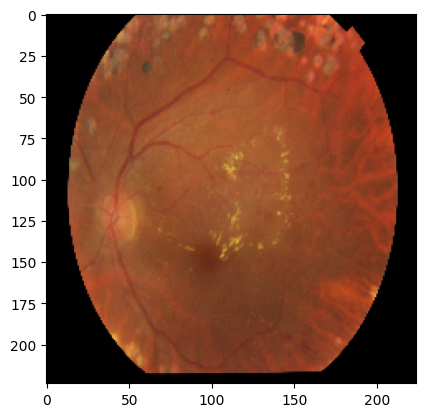

In [33]:
predict_class("D:/Diabetic Retinopathy/APTOS/colored_images/Proliferate_DR/3c78bfca247b.png")

1/1 [==============================] - 0s 150ms/step
No Diabetic Retinopathy is detected


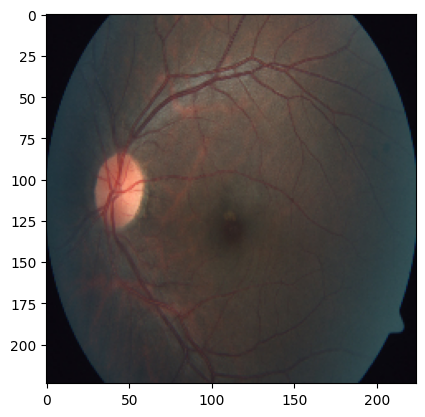

In [34]:
predict_class("D:/Diabetic Retinopathy/APTOS/colored_images/No_DR/0f364b7d4384.png")
